In [2]:
#Load packages and libraries 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import pylab as pl

from sklearn import linear_model

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

# 1. Introduction

Despite the high housing prices in Singapore, buying a house is still a goal for many young Singaporeans. 

However, there seems to be a lack of open-source platforms where individuals can easily access and compare past housing sales transactions and the types and numbers of venues in the different towns. While there are online platforms listing the requested buy prices of apartments, they do not reflect the final sales price and do not currently include information on the number and types of venues in the town where the apartment is located. Hence, this information could be helpful not just for Singaporeans, but could also be used to help investors and expats moving to Singapore who are intending to purchase a resale apartment here, to make a more informed and 

In this project, I will be using housing resale data, retrieved from a government website, to analyze and map out the clusters of towns according to the number of venues and the housing resale prices. Using Multiple Linear Regression, I will also attempt to find out if that model is a suitable one to predict the resale price based on the factors identified (and available to me) - no. of venues in each town (from Foursquare), remaining lease left on apartment and the storey the apartment is on. 

# 2. Methodology 

### 2.1 Data Description 

The datasets used are: 

1. Resale flat prices from 2017 to 2020 March (downloaded from https://data.gov.sg/dataset/resale-flat-prices)

The resale flat prices are for the specific time period above. It contains data on the data of sales transaction, type of flat sold, height of apartment, number of months left on lease, resale price etc. which should be sufficient for my defined scope. 

2. Foursquare API to get the venues of a given town 

Using the Foursquare developer account, I created a new application to retrieve location data based on the coordinates of each town that I will be analyzing. 

### 2.2 Methods Used 

In this section, I will upload, clean the datasets required and give a brief overview of the methods I will be employing in this project. 

I will be using Multiple Linear Regression on the housing sales dataset in an attempt to create a regression model to predict resale price of a HDB apartment based on different x-variables. I will also be using K-means clustering to partition the dataset into clusters. 

In [3]:
#import housing sales dataset 

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ab346872d25942ef81b39a26ea476877 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='OkrI1PxB2ZfQM0_86K6INlZJr2Wyhycbo-ppQ0YTTu5G',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_ab346872d25942ef81b39a26ea476877.get_object(Bucket='capstoneproject-donotdelete-pr-qao4zujurjfbco',Key='resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dfHouse = pd.read_csv(body)

In [4]:
#clean up dataset 
#drop street_name & block & flat model columns

dfHouse.drop(["street_name", "block", "flat_model"], axis=1, inplace=True)
dfHouse.head()


,month,town,flat_type,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,10 TO 12,44.0,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,04 TO 06,68.0,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,1980,62 years 05 months,265000.0


In [5]:
#convert remaining_lease to months only 

dfHouse["remaining_lease_months"] = (dfHouse['remaining_lease'].str.extract('(\d+)').astype(int))*12

In [6]:
#change storey_range to categorical values from 1 to 5

dfHouse.storey_range.unique()
dfHouse.storey_range.astype('category')

conds = [
        (dfHouse['storey_range'] == '01 TO 03'),
        (dfHouse['storey_range'] == '04 TO 06'),
        (dfHouse['storey_range'] == '07 TO 09'),
        (dfHouse['storey_range'] == '10 TO 12'),
        (dfHouse['storey_range'] == '13 TO 15'),
        (dfHouse['storey_range'] == '16 TO 18'),
        (dfHouse['storey_range'] == '19 TO 21'),
        (dfHouse['storey_range'] == '22 TO 24'),
        (dfHouse['storey_range'] == '25 TO 27'),
        (dfHouse['storey_range'] == '28 TO 30'),
        (dfHouse['storey_range'] == '31 TO 33'),
        (dfHouse['storey_range'] == '34 TO 36'),
        (dfHouse['storey_range'] == '37 TO 39'),
        (dfHouse['storey_range'] == '40 TO 42'),
        (dfHouse['storey_range'] == '43 TO 45'),
        (dfHouse['storey_range'] == '46 TO 48'),
        (dfHouse['storey_range'] == '49 TO 51')]

choices = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8]

dfHouse['storey_range'] = np.select(conds, choices)

dfHouse.head()

,month,town,flat_type,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,remaining_lease_months
0,2017-01,ANG MO KIO,2 ROOM,2,44.0,1979,61 years 04 months,232000.0,732
1,2017-01,ANG MO KIO,3 ROOM,1,67.0,1978,60 years 07 months,250000.0,720
2,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,262000.0,744
3,2017-01,ANG MO KIO,3 ROOM,1,68.0,1980,62 years 01 month,265000.0,744
4,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,265000.0,744


In [7]:
dfHouse.storey_range.unique()

array([2, 1, 3, 4, 6, 5, 7, 8])

In [8]:
towns = dfHouse.town.unique()
towns

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [9]:
#define function to get GPS coordinates of each town using geolocator 

dftowns = pd.DataFrame(columns=['Town', 'Latitude', 'Longitude'])

result = []

def getCoord(towns):  
    for i in towns:
        address = i
        geolocator = Nominatim(user_agent="sg_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        result.extend([i, latitude, longitude])   
    return result

In [10]:
#get GPS of each town  
getCoord(towns)

['ANG MO KIO',
 1.3700733,
 103.8495157,
 'BEDOK',
 1.3239765,
 103.930216,
 'BISHAN',
 1.3509859,
 103.84825507492937,
 'BUKIT BATOK',
 1.3490572,
 103.7495906,
 'BUKIT MERAH',
 4.5592879,
 101.0255816,
 'BUKIT PANJANG',
 1.378629,
 103.7621358,
 'BUKIT TIMAH',
 1.3546901,
 103.7763724,
 'CENTRAL AREA',
 36.5070827,
 -79.7447575,
 'CHOA CHU KANG',
 1.3847493,
 103.7445341,
 'CLEMENTI',
 1.3151003,
 103.7652311,
 'GEYLANG',
 1.3181862,
 103.8870563,
 'HOUGANG',
 1.3706821,
 103.8925450111407,
 'JURONG EAST',
 1.333115,
 103.7422968,
 'JURONG WEST',
 1.3396365,
 103.7073387,
 'KALLANG/WHAMPOA',
 1.32975,
 103.8638399,
 'MARINE PARADE',
 1.3026889,
 103.9073952,
 'PASIR RIS',
 1.3730307,
 103.949255,
 'PUNGGOL',
 1.4052585,
 103.9023302,
 'QUEENSTOWN',
 -45.0321923,
 168.661,
 'SEMBAWANG',
 1.4490928,
 103.8200555,
 'SENGKANG',
 1.3916536000000002,
 103.89536361089395,
 'SERANGOON',
 1.3498624,
 103.8737292,
 'TAMPINES',
 1.3546528,
 103.9435712,
 'TOA PAYOH',
 1.3353906,
 103.8497414,
 

In [11]:
#convert list into df townsdata

x = [result[i:i + 3] for i in range(0, len(result), 3)]  
townsdata = pd.DataFrame(x,columns=['Town','Latitude','Longitude'])
townsdata

,Town,Latitude,Longitude
0,ANG MO KIO,1.370073,103.849516
1,BEDOK,1.323976,103.930216
2,BISHAN,1.350986,103.848255
3,BUKIT BATOK,1.349057,103.749591
4,BUKIT MERAH,4.559288,101.025582
5,BUKIT PANJANG,1.378629,103.762136
6,BUKIT TIMAH,1.354690,103.776372
7,CENTRAL AREA,36.507083,-79.744758
8,CHOA CHU KANG,1.384749,103.744534
9,CLEMENTI,1.315100,103.765231


In [12]:
#geolocator seemed to get some of the coordinates wrong; replacing the wrong coordinates in townsdata

townsdata['Latitude'] = townsdata['Latitude'].astype(float)
townsdata['Longitude'] = townsdata['Longitude'].astype(float)

townsdata.iloc[[4],[1]]=1.2819
townsdata.iloc[[4],[2]]=103.8239

townsdata.iloc[[7],[1]]=1.2789
townsdata.iloc[[7],[2]]=103.8536

townsdata.iloc[[18],[1]]=1.2942
townsdata.iloc[[18],[2]]=103.7861

townsdata.iloc[[24],[1]]=1.4382
townsdata.iloc[[24],[2]]=103.789

townsdata

,Town,Latitude,Longitude
0,ANG MO KIO,1.370073,103.849516
1,BEDOK,1.323976,103.930216
2,BISHAN,1.350986,103.848255
3,BUKIT BATOK,1.349057,103.749591
4,BUKIT MERAH,1.281900,103.823900
5,BUKIT PANJANG,1.378629,103.762136
6,BUKIT TIMAH,1.354690,103.776372
7,CENTRAL AREA,1.278900,103.853600
8,CHOA CHU KANG,1.384749,103.744534
9,CLEMENTI,1.315100,103.765231


In [13]:
#display map of SG with towns 

mapSG = folium.Map(location=[1.3521, 103.8198], zoom_start=10)

# add markers to map
for Latitude, Longitude, Town in zip(townsdata['Latitude'], townsdata['Longitude'], townsdata['Town']):
    label = '{}'.format(Town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapSG)  
    
mapSG

Let's use Foursquare API to look at the venues in each town. 

In [14]:
CLIENT_ID = 'KHKNR2ID3YXOC5CZQ1VFZHOG0RXLANFDE4XB0ZNXECDR1NDB' # my Foursquare ID
CLIENT_SECRET = 'RCSYSZNLXU04HTQ0NDGH2EXTA5QIZ5SQK2DMUZVUWFSN11ED' # my Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KHKNR2ID3YXOC5CZQ1VFZHOG0RXLANFDE4XB0ZNXECDR1NDB
CLIENT_SECRET:RCSYSZNLXU04HTQ0NDGH2EXTA5QIZ5SQK2DMUZVUWFSN11ED


In [15]:
#getting the venues for first town in townsdata

town_latitude = townsdata.loc[0, 'Latitude'] # neighborhood latitude value
town_longitude = townsdata.loc[0, 'Longitude'] # neighborhood longitude value

town_name = townsdata.loc[0, 'Town'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(town_name, 
                                                               town_latitude, 
                                                               town_longitude))

Latitude and longitude values of ANG MO KIO are 1.3700733, 103.8495157.


Let's use the GET request url. I will set the limit to 100 venues and the radius around each town to 500m. 

In [16]:
LIMIT = 100
radius = 800
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    town_latitude, 
    town_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KHKNR2ID3YXOC5CZQ1VFZHOG0RXLANFDE4XB0ZNXECDR1NDB&client_secret=RCSYSZNLXU04HTQ0NDGH2EXTA5QIZ5SQK2DMUZVUWFSN11ED&v=20190605&ll=1.3700733,103.8495157&radius=800&limit=100'

In [17]:
results = requests.get(url).json()

In [18]:
# extract the category of the venues requested 

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
#check keys of the results

print(results)

{'meta': {'code': 200, 'requestId': '5ee360d21c213b759826c9ab'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Ang Mo Kio', 'headerFullLocation': 'Ang Mo Kio, Singapore', 'headerLocationGranularity': 'neighborhood', 'totalResults': 71, 'suggestedBounds': {'ne': {'lat': 1.3772733072000072, 'lng': 103.8567043190824}, 'sw': {'lat': 1.362873292799993, 'lng': 103.8423270809176}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b15f661f964a52012b623e3', 'name': 'FairPrice Xtra', 'location': {'address': '#B2-26 AMK Hub', 'crossStreet': '53 Ang Mo Kio Ave 3', 'lat': 1.3692792884081397, 'lng': 103.84888576818767, 'labeledLatLngs': [{'label': 'display', 'lat': 1.3692792884081397, 'lng': 103.84888576818767}], 'distance': 112, 'postalCo

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# count numbers of venues returned by Foursquare
nearby_venues.shape
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

71 venues were returned by Foursquare.


Now let's define a function to get all the venues in every town. 

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
sgVenues = getNearbyVenues(names=townsdata['Town'],
                                   latitudes=townsdata['Latitude'],
                                   longitudes=townsdata['Longitude']
                                  )

ANG MO KIO
BEDOK
BISHAN
BUKIT BATOK
BUKIT MERAH
BUKIT PANJANG
BUKIT TIMAH
CENTRAL AREA
CHOA CHU KANG
CLEMENTI
GEYLANG
HOUGANG
JURONG EAST
JURONG WEST
KALLANG/WHAMPOA
MARINE PARADE
PASIR RIS
PUNGGOL
QUEENSTOWN
SEMBAWANG
SENGKANG
SERANGOON
TAMPINES
TOA PAYOH
WOODLANDS
YISHUN


In [23]:
print(sgVenues.shape)
sgVenues.head()

(1577, 7)


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ANG MO KIO,1.370073,103.849516,FairPrice Xtra,1.369279,103.848886,Supermarket
1,ANG MO KIO,1.370073,103.849516,Old Chang Kee,1.369094,103.848389,Snack Place
2,ANG MO KIO,1.370073,103.849516,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
3,ANG MO KIO,1.370073,103.849516,NTUC FairPrice,1.371507,103.847082,Supermarket
4,ANG MO KIO,1.370073,103.849516,MOS Burger,1.369170,103.847831,Burger Joint


Now that we have the sgVenues dataframe, we can count how many venues there are in each town.

In [24]:
summary = sgVenues.groupby('Town').count().reset_index()
summary['Venues Count'] = summary['Venue']
summary = summary.drop(['Town Latitude', 'Town Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Venues Count').reset_index(drop=True)
summary

,Town,Venues Count
0,SEMBAWANG,23
1,CHOA CHU KANG,26
2,SENGKANG,26
3,BUKIT TIMAH,26
4,BUKIT BATOK,33
5,KALLANG/WHAMPOA,39
6,PUNGGOL,49
7,BUKIT PANJANG,51
8,BUKIT MERAH,53
9,BISHAN,55


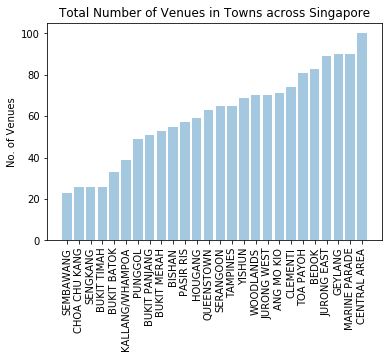

In [25]:
import matplotlib.pyplot as plt

town_label = summary.Town
y_pos = np.arange(len(town_label))
performance = summary['Venues Count']

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, town_label)
plt.ylabel('No. of Venues')
plt.title('Total Number of Venues in Towns across Singapore')
plt.xticks(rotation=90)

plt.show()

We can see that 'Central Area' has the most number of venues (there could be more than 100 venues within 500m radius set; since limit was set to 100), and Sembawang has the fewest number of venues within 500m radius. 

Now, let's dig a bit deeper to find out the no. of unique categories of venues in each town, and use one hot encoding to sort each town's venue categories.

In [26]:
#no. of unique venue categories in sgVenues dataframe
len(sgVenues['Venue Category'].unique())

215

In [71]:
# one hot encoding
sg_onehot = pd.get_dummies(sgVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Town'] = sgVenues['Town'] 

# move neighborhood column to the first column
list_column = sg_onehot.columns.tolist()
number_column = int(list_column.index('Town'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
sg_onehot = sg_onehot[list_column]

#grouping by towns 

sg_onehot_grouped = sg_onehot.groupby('Town').mean().reset_index()
sg_onehot_grouped.head()

,Town,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bay,Beach,Beer Bar,Beer Garden,Bike Trail,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Church,Circus,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,High School,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lounge,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Moving Target,Multiplex,Nature Preserve,Neighborhood,Night Market,Noodle House,Office,Optical Shop,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,TV Station,Tea Room,Tennis Stadium,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Yunnan Restaurant
0,ANG MO KIO,0.0,0.000000,0.014085,0.0,0.0,0.0,0.000000,0.042254,0.0,0.0,0.014085,0.0,0.028169,0.014085,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.000000,0.0,0.000000,0.014085,0.0,0.028169,0.000000,0.0,0.014085,0.000000,0.014085,0.014085,0.0,0.0,0.000000,0.014085,0.0,0.0,0.0,0.028169,0.0,0.0,0.000000,0.0,0.0,0.084507,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.014085,0.042254,0.0,0.0,0.0,0.014085,0.000000,0.014085,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.0,0.183099,0.000000,0.000000,0.014085,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.014085,0.014085,0.014085,0.0,0.0,0.014085,0.0,0.0,0.0,0.014085,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.014085,0.000000,0.000000,0.0,0.028169,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.000000,0.014085,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.01

In [72]:
#define function to sort venues in descending order 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Using the function defined above, we can now sort the venue categories and display the "Top 10 Venue Categories" on each town in descending order. 

In [73]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sg_venues_sorted = pd.DataFrame(columns=columns)
sg_venues_sorted['Town'] = sg_onehot_grouped['Town']

for ind in np.arange(sg_onehot_grouped.shape[0]):
    sg_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_onehot_grouped.iloc[ind, :], num_top_venues)

sg_venues_sorted.head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ANG MO KIO,Food Court,Coffee Shop,Dessert Shop,Asian Restaurant,Vegetarian / Vegan Restaurant
1,BEDOK,Coffee Shop,Chinese Restaurant,Food Court,Café,Japanese Restaurant
2,BISHAN,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Thai Restaurant
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Grocery Store
4,BUKIT MERAH,Chinese Restaurant,Coffee Shop,Food Court,Fast Food Restaurant,Café


As expected of Singapore, the top venue category in every town is a type of food establishment, with the exception of Bukit Timah and Sengkang. 

Next, let's add in the frequencies of these top 5 venue categories for each town from the sg_onehot_grouped df.

In [74]:
# loop through dataframes to fill in values 

#for i in sg_onehot_grouped.columns:
    
    #print (i)
    #if i == sg_venues_sorted['1st Most Common Venue'].any():
    #if i.isin(sg_venues_sorted['1st Most Common Venue']).any():
        #print (i)
        #sg_venues_sorted = sg_venues_sorted.append(sg_onehot_grouped[i], ignore_index=True)
    #else: 
        #print ('No')
        

In [75]:
def create_col(x):
    return sg_onehot_grouped.loc[sg_onehot_grouped.Town==x['Town'],x[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']]].values[0]

sg_venues_sorted['1st Most Common Venue Freq'],sg_venues_sorted['2nd Most Common Venue Freq'],sg_venues_sorted['3rd Most Common Venue Freq'],sg_venues_sorted['4th Most Common Venue Freq'],sg_venues_sorted['5th Most Common Venue Freq'] = zip(*sg_venues_sorted.apply(lambda x: create_col(x),axis=1))

In [76]:
sg_venues_sorted

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq
0,ANG MO KIO,Food Court,Coffee Shop,Dessert Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,0.183099,0.084507,0.042254,0.042254,0.028169
1,BEDOK,Coffee Shop,Chinese Restaurant,Food Court,Café,Japanese Restaurant,0.096386,0.084337,0.072289,0.060241,0.036145
2,BISHAN,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Thai Restaurant,0.090909,0.072727,0.054545,0.054545,0.036364
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Grocery Store,0.181818,0.121212,0.090909,0.060606,0.030303
4,BUKIT MERAH,Chinese Restaurant,Coffee Shop,Food Court,Fast Food Restaurant,Café,0.132075,0.094340,0.075472,0.056604,0.056604
5,BUKIT PANJANG,Café,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,0.078431,0.078431,0.078431,0.058824,0.058824
6,BUKIT TIMAH,Trail,Rest Area,Nature Preserve,Scenic Lookout,Mountain,0.461538,0.115385,0.076923,0.076923,0.076923
7,CENTRAL AREA,Café,Coffee Shop,Hotel,Waterfront,Plaza,0.060000,0.060000,0.050000,0.040000,0.030000
8,CHOA CHU KANG,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Noodle House,Thai Restaurant,0.115385,0.076923,0.076923,0.038462,0.038462
9,CLEMENTI,Chinese Restaurant,Food Court,Asian Restaurant,Thai Restaurant,Gym,0.094595,0.081081,0.054054,0.040541,0.040541


Let's try to represent this information visually using a bar chart.

Text(0, 0.5, 'Type of Venue')

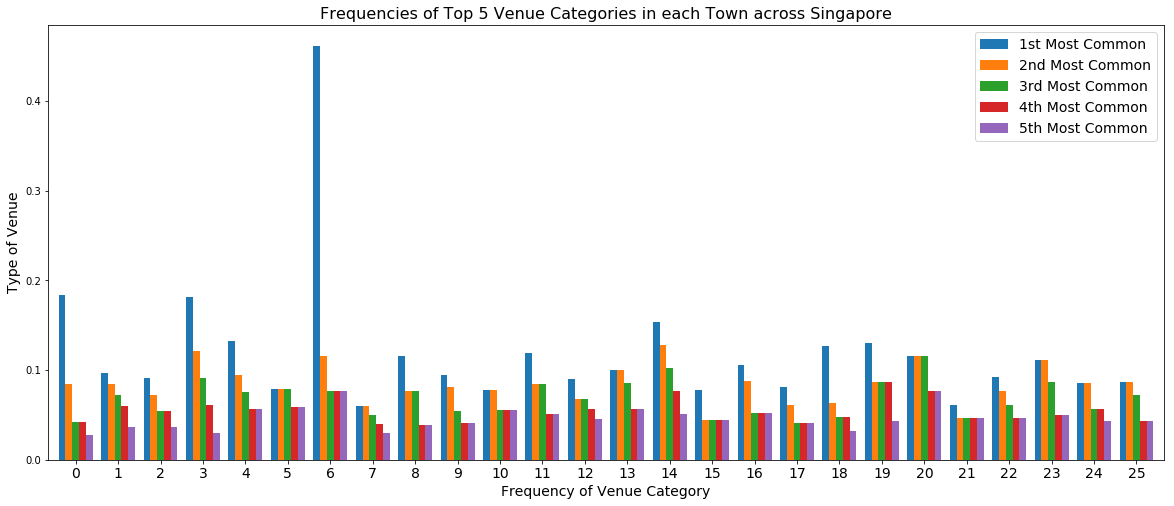

In [77]:
#plot frequencies of top 5 venues on bar chart

import matplotlib.pyplot as plt

frame=sg_venues_sorted.iloc[:,6:].plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=('1st Most Common','2nd Most Common','3rd Most Common','4th Most Common','5th Most Common'), fontsize = 14)
plt.title("Frequencies of Top 5 Venue Categories in each Town across Singapore",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Frequency of Venue Category', fontsize=14)
plt.ylabel('Type of Venue', fontsize=14)

In [78]:
#change column 'town' in dfHouse to 'Town'
dfHouse.rename(columns={'town': 'Town'}, inplace=True)

#add no. of venues of each town into dfHouse df
dfHouse2 = pd.merge(dfHouse, summary)

In [79]:
dfHouse2.head()

,month,Town,flat_type,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,remaining_lease_months,Venues Count
0,2017-01,ANG MO KIO,2 ROOM,2,44.0,1979,61 years 04 months,232000.0,732,71
1,2017-01,ANG MO KIO,3 ROOM,1,67.0,1978,60 years 07 months,250000.0,720,71
2,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,262000.0,744,71
3,2017-01,ANG MO KIO,3 ROOM,1,68.0,1980,62 years 01 month,265000.0,744,71
4,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,265000.0,744,71


In [80]:
#filter out for Ang Mo Kio area

dfHouse2_AMK = dfHouse2[dfHouse2.Town == 'ANG MO KIO']

dfHouse2_AMK.head()

,month,Town,flat_type,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,remaining_lease_months,Venues Count
0,2017-01,ANG MO KIO,2 ROOM,2,44.0,1979,61 years 04 months,232000.0,732,71
1,2017-01,ANG MO KIO,3 ROOM,1,67.0,1978,60 years 07 months,250000.0,720,71
2,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,262000.0,744,71
3,2017-01,ANG MO KIO,3 ROOM,1,68.0,1980,62 years 01 month,265000.0,744,71
4,2017-01,ANG MO KIO,3 ROOM,1,67.0,1980,62 years 05 months,265000.0,744,71


/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Resale Prices of Apartments vs. Remaining Lease Months in Ang Mo Kio')

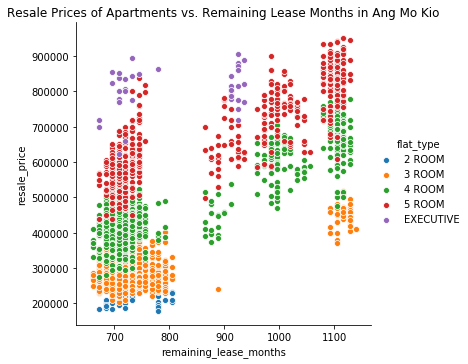

In [81]:
#scatter plot data of house sale price with storey height, grouped by flat_type for Ang Mo Kio

import seaborn as sns

sns.pairplot(x_vars=["remaining_lease_months"], y_vars=["resale_price"], data=dfHouse2_AMK, hue="flat_type", size=5)
plt.title("Resale Prices of Apartments vs. Remaining Lease Months in Ang Mo Kio")

In [82]:
#filter out data for 5-room resale flats in all towns

dfHouse2_5rm = dfHouse2[dfHouse2.flat_type == '5 ROOM']
dfHouse2_5rm.head()

,month,Town,flat_type,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,remaining_lease_months,Venues Count
49,2017-01,ANG MO KIO,5 ROOM,1,117.0,1978,60 years 01 month,500000.0,720,71
50,2017-01,ANG MO KIO,5 ROOM,3,119.0,1979,61 years,668000.0,732,71
51,2017-01,ANG MO KIO,5 ROOM,4,118.0,1980,62 years 08 months,668000.0,744,71
52,2017-01,ANG MO KIO,5 ROOM,3,119.0,1980,62 years 05 months,725000.0,744,71
53,2017-01,ANG MO KIO,5 ROOM,2,112.0,2011,93 years 07 months,770000.0,1116,71


Text(0.5, 0.98, 'Boxplot of 5-Room HDB Prices in different Towns across Singapore')

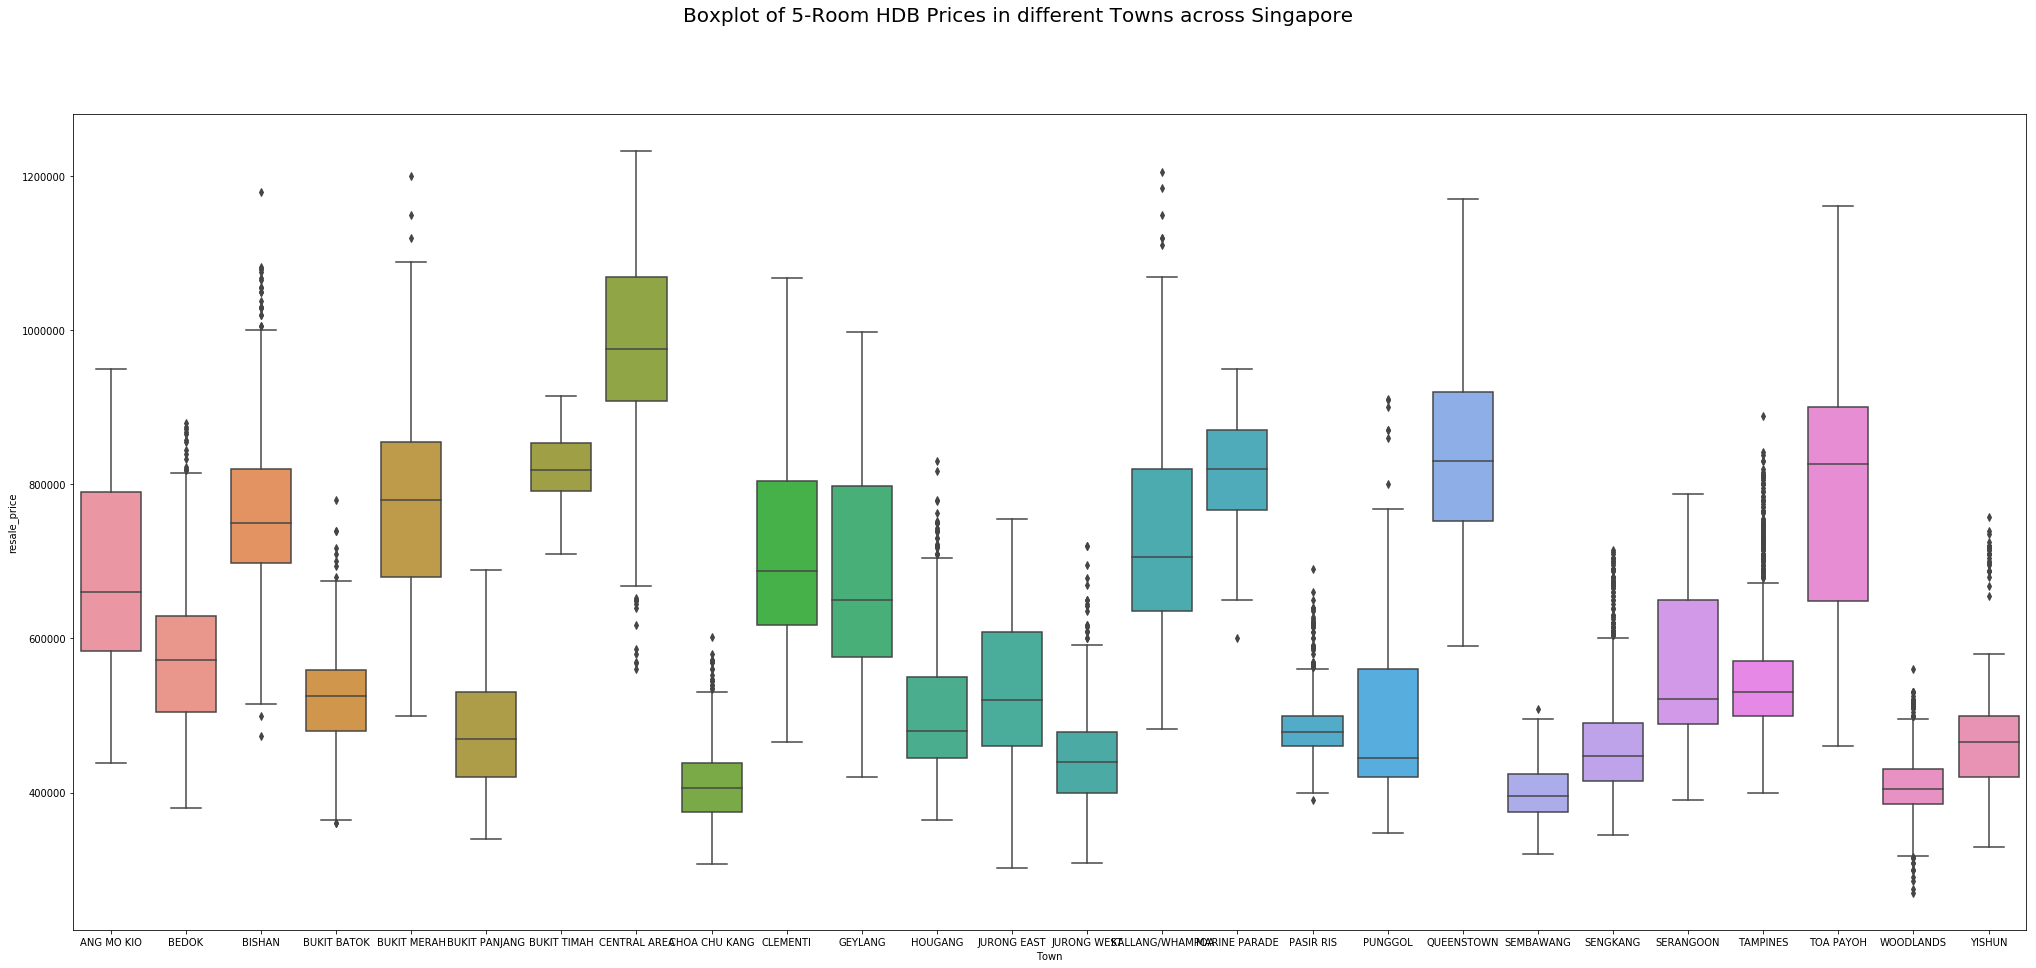

In [83]:
#box plot of 5-room apartments in different Towns 
from matplotlib import pyplot as plt

ax = sns.boxplot(x="Town", y="resale_price", data=dfHouse2_5rm)
fig = plt.gcf()
fig.set_size_inches(35, 15)
fig.suptitle('Boxplot of 5-Room HDB Prices in different Towns across Singapore', fontsize=20)

In general, Pasir Ris, Sembawang and Woodlands show a narrower range of resale prices compared to the other towns. 

# 3. Results 

### 3.1 Multiple Linear Regression

Let's try to perform a multiple linear regression to draw the relationships between each x-variable (storey range, no. of venues in the town, remaining lease) and our target y-variable (house sale price) to predict house resale prices. 

In [84]:
#split into train/test data 

msk = np.random.rand(len(dfHouse2)) < 0.8
train = dfHouse2[msk]
test = dfHouse2[~msk]

In [85]:
#perform multiple linear regression fit using train data 

from sklearn import linear_model

regr = linear_model.LinearRegression(normalize=True)  #normalize data
x = np.asanyarray(train[['storey_range','remaining_lease_months','Venues Count']])
y = np.asanyarray(train[['resale_price']])
regr.fit(x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[46932.20138047   295.74776595  1055.521916  ]]


In [86]:
#predict using test data 

y_hat= regr.predict(test[['storey_range','remaining_lease_months','Venues Count']])
x = np.asanyarray(test[['storey_range','remaining_lease_months','Venues Count']])
y = np.asanyarray(test[['resale_price']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 18555817892.24
Variance score: 0.20


Variance score of 0.20 is very low, hence the multiple linear regression model is not a good fit for the data.

### 3.2 K-means Clustering

I will also run K-means to cluster the data into 5 clusters.

In [100]:
#calculate mean resale price of apartment in each town and insert into sg_grouped_clustering df

resale_price_mean = pd.DataFrame(dfHouse.groupby('Town')['resale_price'].mean())
resale_price_mean.head()

#join resale_price_mean into sg_onehot_grouped df
sg_onehot_grouped = sg_onehot_grouped.join(resale_price_mean, on='Town')
sg_onehot_grouped.head()

,Town,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bay,Beach,Beer Bar,Beer Garden,Bike Trail,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Church,Circus,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,High School,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Lounge,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Moving Target,Multiplex,Nature Preserve,Neighborhood,Night Market,Noodle House,Office,Optical Shop,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,TV Station,Tea Room,Tennis Stadium,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Yunnan Restaurant,resale_price
0,ANG MO KIO,0.0,0.000000,0.014085,0.0,0.0,0.0,0.000000,0.042254,0.0,0.0,0.014085,0.0,0.028169,0.014085,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.000000,0.0,0.000000,0.014085,0.0,0.028169,0.000000,0.0,0.014085,0.000000,0.014085,0.014085,0.0,0.0,0.000000,0.014085,0.0,0.0,0.0,0.028169,0.0,0.0,0.000000,0.0,0.0,0.084507,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.014085,0.042254,0.0,0.0,0.0,0.014085,0.000000,0.014085,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.0,0.183099,0.000000,0.000000,0.014085,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.014085,0.014085,0.014085,0.0,0.0,0.014085,0.0,0.0,0.0,0.014085,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.014085,0.000000,0.000000,0.0,0.028169,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.000000,0.014085,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [101]:
# set number of clusters
kclusters = 5

sg_grouped_clustering = sg_onehot_grouped.drop(['Town'], axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 2, 3, 0, 1, 1, 2, 4], dtype=int32)

Now that we've got the cluster label each town, I will add it to the sg_venues_sorted dataframe.

In [103]:
#reset cluster col
sg_venues_sorted = sg_venues_sorted.drop(['Cluster Labels'], axis = 1)

# add clustering labels
sg_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = townsdata

# merge sg_venues_sorted with townsdata to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(sg_venues_sorted.set_index('Town'), on='Town')

sg_merged.head() # check the last columns!

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
0,ANG MO KIO,1.370073,103.849516,0,Food Court,Coffee Shop,Dessert Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,0.183099,0.084507,0.042254,0.042254,0.028169,410806.867470
1,BEDOK,1.323976,103.930216,0,Coffee Shop,Chinese Restaurant,Food Court,Café,Japanese Restaurant,0.096386,0.084337,0.072289,0.060241,0.036145,410129.715166
2,BISHAN,1.350986,103.848255,1,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Thai Restaurant,0.090909,0.072727,0.054545,0.054545,0.036364,642492.949091
3,BUKIT BATOK,1.349057,103.749591,2,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Grocery Store,0.181818,0.121212,0.090909,0.060606,0.030303,377811.132375
4,BUKIT MERAH,1.281900,103.823900,3,Chinese Restaurant,Coffee Shop,Food Court,Fast Food Restaurant,Café,0.132075,0.094340,0.075472,0.056604,0.056604,564744.343143


Finally, let's visualize and explore the clusters formed using k-means clustering. 

In [104]:
# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['Town'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [105]:
#cluster 1
sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,Town,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
0,ANG MO KIO,Coffee Shop,Dessert Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,0.183099,0.084507,0.042254,0.042254,0.028169,410806.867470
1,BEDOK,Chinese Restaurant,Food Court,Café,Japanese Restaurant,0.096386,0.084337,0.072289,0.060241,0.036145,410129.715166
5,BUKIT PANJANG,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,0.078431,0.078431,0.078431,0.058824,0.058824,426743.474589
10,GEYLANG,Chinese Restaurant,Noodle House,Fast Food Restaurant,Food Court,0.077778,0.077778,0.055556,0.055556,0.055556,427936.482430
11,HOUGANG,Bus Station,Food Court,Asian Restaurant,Chinese Restaurant,0.118644,0.084746,0.084746,0.050847,0.050847,430155.642536
12,JURONG EAST,Food Court,Chinese Restaurant,Coffee Shop,Café,0.089888,0.067416,0.067416,0.056180,0.044944,415031.501928
17,PUNGGOL,Fast Food Restaurant,Japanese Restaurant,Steakhouse,Food Court,0.081633,0.061224,0.040816,0.040816,0.040816,453433.421536
20,SENGKANG,Fast Food Restaurant,Coffee Shop,Bus Station,Supermarket,0.115385,0.115385,0.115385,0.076923,0.076923,435064.926308


In [106]:
#cluster 2
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,Town,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
2,BISHAN,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Thai Restaurant,0.090909,0.072727,0.054545,0.054545,0.036364,642492.949091
6,BUKIT TIMAH,Rest Area,Nature Preserve,Scenic Lookout,Mountain,0.461538,0.115385,0.076923,0.076923,0.076923,713244.212121
7,CENTRAL AREA,Coffee Shop,Hotel,Waterfront,Plaza,0.060000,0.060000,0.050000,0.040000,0.030000,618958.450947


In [107]:
#cluster 3
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,Town,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
3,BUKIT BATOK,Food Court,Chinese Restaurant,Fast Food Restaurant,Grocery Store,0.181818,0.121212,0.090909,0.060606,0.030303,377811.132375
8,CHOA CHU KANG,Asian Restaurant,Fast Food Restaurant,Noodle House,Thai Restaurant,0.115385,0.076923,0.076923,0.038462,0.038462,384807.756860
13,JURONG WEST,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,0.100000,0.100000,0.085714,0.057143,0.057143,388402.428128
19,SEMBAWANG,Fast Food Restaurant,Park,Food Court,Japanese Restaurant,0.130435,0.086957,0.086957,0.086957,0.043478,378817.504728
24,WOODLANDS,Café,Japanese Restaurant,Shopping Mall,Fast Food Restaurant,0.085714,0.085714,0.057143,0.057143,0.042857,377327.763305
25,YISHUN,Coffee Shop,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,0.086957,0.086957,0.072464,0.043478,0.043478,362004.767936


In [108]:
#cluster 4
sg_merged.loc[sg_merged['Cluster Labels'] == 3, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,Town,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
4,BUKIT MERAH,Coffee Shop,Food Court,Fast Food Restaurant,Café,0.132075,0.094340,0.075472,0.056604,0.056604,564744.343143
18,QUEENSTOWN,Café,Salad Place,Sandwich Place,Bus Station,0.126984,0.063492,0.047619,0.047619,0.031746,553090.367701


In [109]:
#cluster 5
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,Town,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Common Venue Freq,2nd Most Common Venue Freq,3rd Most Common Venue Freq,4th Most Common Venue Freq,5th Most Common Venue Freq,resale_price
9,CLEMENTI,Food Court,Asian Restaurant,Thai Restaurant,Gym,0.094595,0.081081,0.054054,0.040541,0.040541,474134.894048
14,KALLANG/WHAMPOA,Chinese Restaurant,Convenience Store,Fast Food Restaurant,Bus Line,0.153846,0.128205,0.102564,0.076923,0.051282,495661.470473
15,MARINE PARADE,Japanese Restaurant,Bakery,Hotel,Coffee Shop,0.077778,0.044444,0.044444,0.044444,0.044444,512389.086538
16,PASIR RIS,Food Court,Pool,Asian Restaurant,Park,0.105263,0.087719,0.052632,0.052632,0.052632,492148.189911
21,SERANGOON,Café,Ice Cream Shop,Coffee Shop,Chinese Restaurant,0.061538,0.046154,0.046154,0.046154,0.046154,490229.443350
22,TAMPINES,Café,Bakery,Supermarket,Bubble Tea Shop,0.092308,0.076923,0.061538,0.046154,0.046154,473972.974675
23,TOA PAYOH,Chinese Restaurant,Food Court,Snack Place,Asian Restaurant,0.111111,0.111111,0.086420,0.049383,0.049383,491197.391323


## 4. Discussion

Overall, I performed data analysis on the resale prices dataset to find out if (i) multiple linear regression can be a suitable predictive model; (ii) and used unsupervised k-means clustering to segment the dataset. However, it should be noted that only 27 towns coordinates were used; to achieve higher granularity, each town can be split further into sub-areas and analyzed on the deeper level instead.  

### 4.1 Characteristics of each Cluster 

#### Cluster 1

This cluster has the lowest range of housing resale prices amongst all 5 clusters. In terms of venue categories, there seems to be no lack of eating options around the towns, with coffee shops and restaurants dominating most of the towns. 

#### Cluster 2

This cluster has the highest housing resale prices. Coffee shops seem to be the top venue category found in 2 of the 3 towns in this cluster, whilst the last town is where a nature reserve is located. 

Interestingly, food courts and restaurants which seem to dominate the other clusters are less commonly found in this one.

#### Cluster 3

This cluster has low to mid-range housing resale prices. There seems to be a high diversity of restaurants and cafes found in this cluster, as well as fast food options. 

#### Clusters 4 & 5

Both of these clusters have mid-range resale prices. Cafe and coffee shops are the top venue categories for these 2 towns. Perhaps one distinctive feature would be more recreation areas found in Cluster 5.

### 4.2 Multiple Linear Regression Model

Based on the results, Multiple Linear Regression may not be the right model to predict the resale price of an apartment in Singapore, based on the low variance value. It will take further study to find out a more appropriate model.



### 4.3 Potential Scope for Further Studies

While looking at the cluster results, I realized that I should have accounted for the high density of eating areas found across all areas in Singapore. Perhaps I could have grouped the eating venue categories into 3 - 5 groups, before running the one-hot encoding. This would have allowed some other types of venue categories to be accounted for in the clustering, and enabled further insights during the clustering of dataset. 

In this study, time was not included as a factor. It might be interesting to look at resale prices patterns in different over the years, especially during the sharp drop in housing prices back in 2008. 

Some possible questions to be further explored: 

1. How quickly did the housing prices in different towns bounce back post-crisis? 
2. What factor/s have the highest correlation to the strength of the recovery? 
3. Time factor aside, do different factors affect the resale price of apartments in each town to different degree? 

Such questions could potentially help a home buyer decide which type of apartment would be the most stable and resilient in sales price. 

# 5. Conclusion

Home buying remains a goal for many Singaporeans. Hopefully, analysis of such resale prices can help young buyers decide where to make their home purchase. 

Unfortunately, this project was not successful in creating a reliable predictive regression model for this predicting resale prices based on the data given. Further exploration can be done in this aspect, to help buyers plan ahead for their purchase.  